<a href="https://colab.research.google.com/github/FUHAR-GARG/Flower_Image_classifier/blob/main/Flower_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"

In [3]:
!python -m pip install torch==1.0.0

ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0)
ERROR: No matching distribution found for torch==1.0.0


In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu118
True


In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from collections import OrderedDict

from PIL import Image

torch.manual_seed(47);

In [6]:
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers

--2023-10-09 16:15:42--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.225.104, 52.217.116.224, 52.217.194.200, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.225.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  55.3MB/s    in 6.2s    

2023-10-09 16:15:49 (53.0 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]

unlink: cannot unlink 'flowers': No such file or directory


In [7]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [8]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [9]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [10]:
cat_num = len(cat_to_name)
print("Dictionary w/ category as key and name as value: \n\n", cat_to_name)
print("\nCategory number: {}".format(cat_num))


Dictionary w/ category as key and name as value: 

 {'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion

In [11]:
# TODO: Build and train your network

# Train on GPU if availiable; if not, cpu.
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transfer learning; load pretrained model: VGG16
model = models.vgg16(pretrained=True)
print("Pretrained model: \n\n", model)

# Freeze model parameters when training; turn off gradients for our model
for param in model.parameters():
    param.requires_grad = False
# Define new classifier
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4000)),
    ('act1', nn.ReLU()),
    ('drop1', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(4000, 640)),
    ('act2', nn.ReLU()),
    ('drop2', nn.Dropout(p=0.2)),
    ('fc3', nn.Linear(640, cat_num)),
    ('output', nn.LogSoftmax(dim=1))
]))
model.classifier = classifier
print("Pretrained model w/ updated classifier: \n\n", model)

criterion = nn.NLLLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
model.to(device);

# Train model
epochs = 3
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    # Training loop
    for images, labels in train_loader:
        steps += 1
        # Move images & labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        # Set gradients to zero
        optimizer.zero_grad()
        # Feedforward
        logps = model(images)
        loss = criterion(logps, labels)
        # Backpropagation
        loss.backward()
        # Gradient descent
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            # Turn on evaluation, inference mode; turn off dropout
            model.eval()
            valid_loss = 0
            accuracy = 0
            # Turn off autograd
            with torch.no_grad():
                # Validation loop
                for images, labels in valid_loader:
                    # Move images & labels to GPU if available
                    images, labels = images.to(device), labels.to(device)
                    logps = model(images)
                    batch_loss = criterion(logps, labels)
                    valid_loss += batch_loss.item()
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_ps, top_class = ps.topk(1, dim=1)
                    equality = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equality.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}.. ")

            running_loss = 0

            # Set model back to training mode
            model.train()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 299MB/s]


Pretrained model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

In [12]:
# Turn on evaluation, inference mode; turn off dropout
model.to(device)
model.eval()
accuracy = 0

with torch.no_grad():


    for images, labels in test_loader:


        images, labels = images.to(device), labels.to(device)


        logps = model(images)


        ps = torch.exp(logps)
        top_ps, top_class = ps.topk(1, dim=1)
        equality = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equality.type(torch.FloatTensor)).item()

    print(f"Test accuracy: {accuracy/len(test_loader):.3f}")


model.train();

Test accuracy: 0.823


In [13]:
model.class_to_idx = train_dataset.class_to_idx

checkpoint = {'input_size': 25088,
              'output_size': cat_num,
              'pretrained_model': models.vgg16(pretrained=True),
              'classifier': model.classifier,
              'state_dict': model.state_dict(),
              'optimizer': optimizer,
              'learning_rate': learning_rate,
              'epochs': epochs,
              'class_to_idx': model.class_to_idx
              }

torch.save(checkpoint, 'checkpoint.pth')

In [14]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    model = checkpoint['pretrained_model']

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    model.optimizer = checkpoint['optimizer']
    model.learning_rate = checkpoint['learning_rate']
    model.epochs = checkpoint['epochs']
    model.class_to_idx = checkpoint['class_to_idx']

    return model

model = load_checkpoint('checkpoint.pth')
print("Loaded model: \n\n", model)

Loaded model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padd

In [16]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # TODO: Process a PIL image for use in a PyTorch model

    # Get image original sizes
    w, h = image.size

    # Resize image
    if w > h:
        ratio = w/h
        image.thumbnail((w*ratio, 256))
    else:
        ratio = h/w
        image.thumbnail((256, h*ratio))

    # Crop image
    w, h = image.size
    left = (w-224)/2
    upper = (h-224)/2
    right = left + 224
    lower = upper + 224
    image = image.crop((left, upper, right, lower))

    # Change color channels to be between 0 and 1
    image = np.array(image)
    image = image/225.

    # Normalize image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean)/std

    # Reorder NumPy and PIL
    image = np.transpose(image, (2, 0, 1))

    return image

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    image = image.transpose((1, 2, 0))


    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean


    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

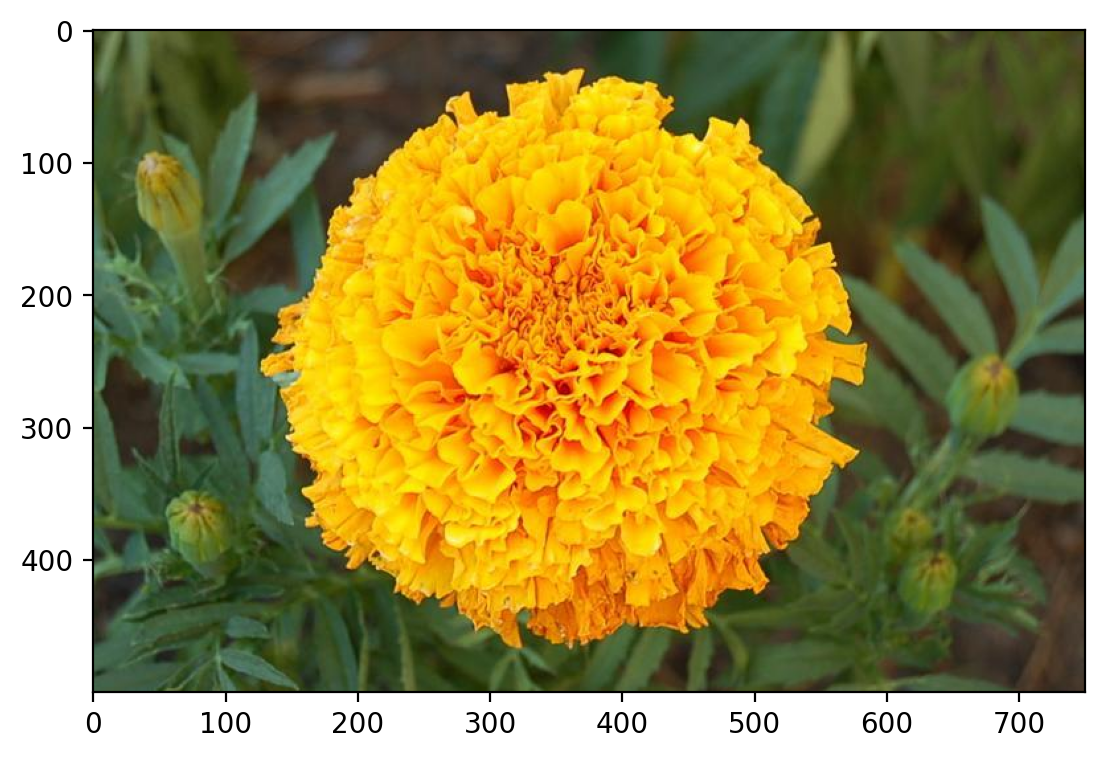

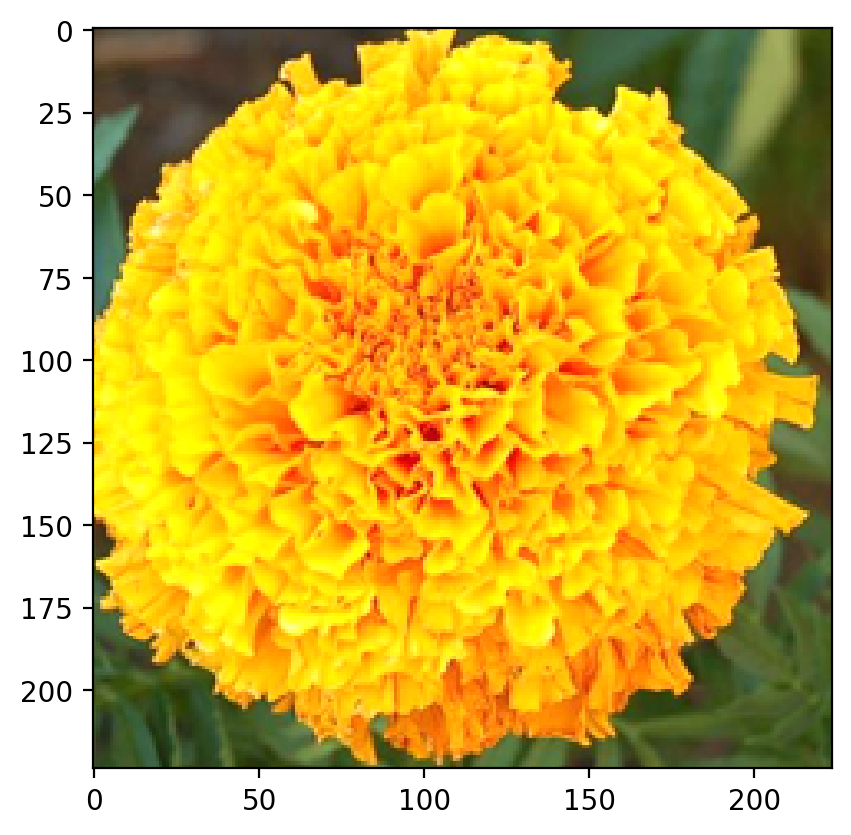

In [23]:
# Class 47: Marigold
image_path = "flowers/test/47/image_04966.jpg"

# original image
with Image.open(image_path) as image:
    plt.imshow(image)

# Processed image
with Image.open(image_path) as image:
    imshow(process_image(image))

In [19]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # TODO: Implement the code to predict the class from an image file
    model.to(device)
    model.eval()

    image = Image.open(image_path)
    image = process_image(image)
    image = torch.from_numpy(image)
    image = image.float()
    image.unsqueeze_(0)

    image = image.to(device)

    # Turn off autograd
    with torch.no_grad():

        # Feedworwad
        logps = model(image)

        # Calculate probability
        ps = torch.exp(logps).cpu()
        top_ps, top_class = ps.topk(topk, dim=1)

        top_ps = np.array(top_ps[0])
        top_class = np.array(top_class[0])

    model.train()

    # Convert indices to actual category names
    index_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_class = [index_to_class[idx] for idx in top_class]

    return top_ps, top_class

In [20]:
# Class 47: Marigold
image_path = "flowers/test/47/image_04966.jpg"
probs, classes = predict(image_path, model)
print (probs)
print (classes)

[8.89331937e-01 1.07840985e-01 2.37769424e-03 1.66817641e-04
 1.43886049e-04]
['47', '50', '5', '48', '31']


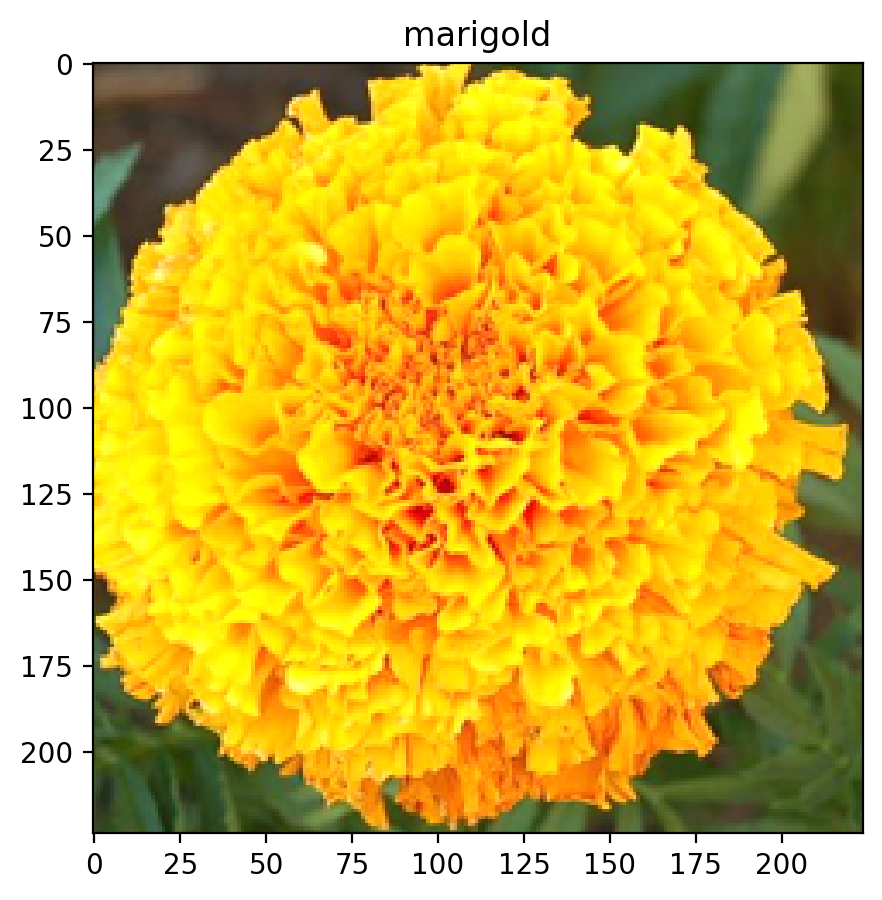

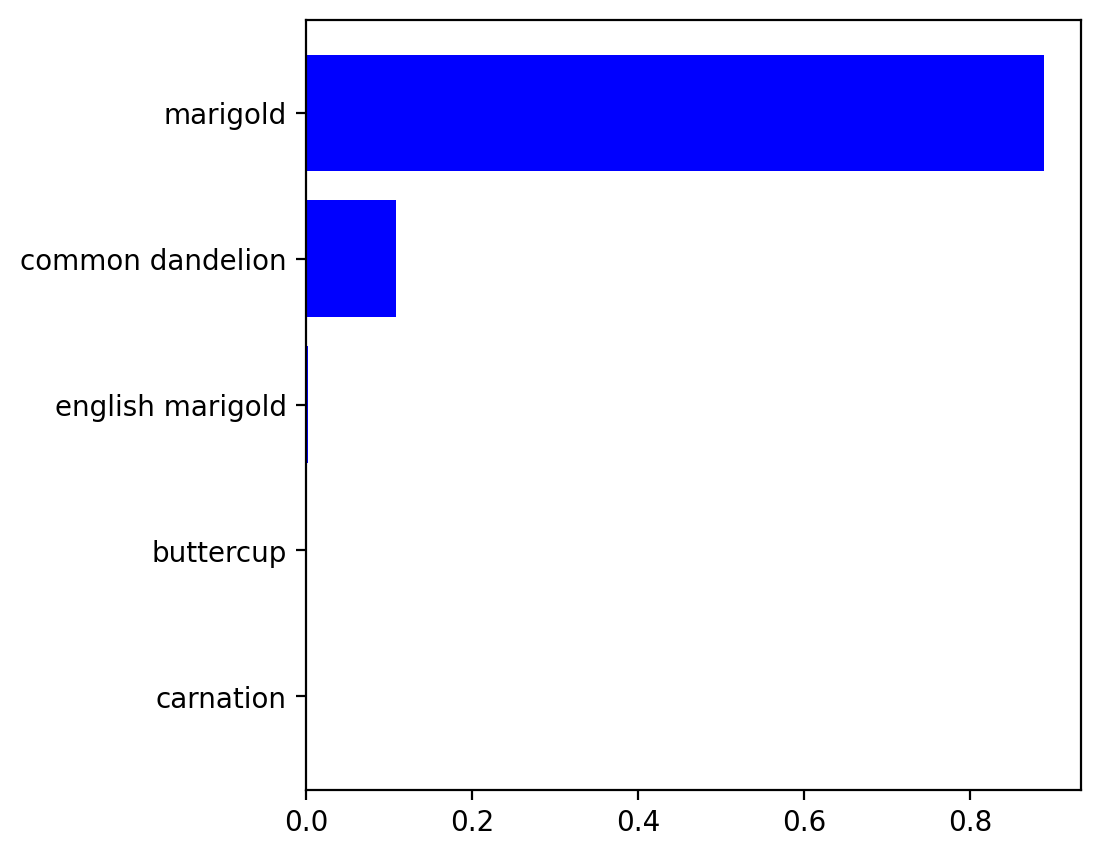

In [21]:
plt.figure(figsize=(5,5))

# Class 47: Marigold
image_path = "flowers/test/47/image_04966.jpg"

probs, classes = predict(image_path, model)
image = Image.open(image_path)
image = process_image(image)
first_idx = classes[0]

axs = imshow(image, ax = plt)
axs.title(cat_to_name[str(first_idx)])
axs.show()

plt.figure(figsize=(5,5))

names = [cat_to_name[str(idx)] for idx in classes]
y_pos = np.arange(len(names))
performance = np.array(probs)

plt.barh(y_pos, performance, align='center', color='blue')
plt.yticks(y_pos, names)
plt.gca().invert_yaxis()